In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns

import xgboost as xgb
from xgboost import plot_importance, plot_tree
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from tqdm import tqdm
from itertools import product

In [3]:
from codecarbon import EmissionsTracker

codecarbon_output = "./codecarbon_emissions.csv"

In [5]:
df = pd.read_csv('Interpolado_jacarepagua.csv', sep=',')
df

,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (Kj/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",datetime
0,0.0,1016.5,1017.0,1016.5,518.5,19.2,14.6,20.2,19.2,14.6,13.2,75.0,65.0,75.0,27.0,4.4,1.2,2017-08-11 19:00:00
1,0.0,1016.5,1017.0,1016.5,169.9,18.9,14.0,19.5,18.9,14.8,13.9,75.0,71.0,73.0,242.0,2.6,0.8,2017-08-11 20:00:00
2,0.0,1016.5,1017.0,1016.5,17.5,18.1,14.4,18.9,18.1,14.4,14.0,79.0,73.0,79.0,230.0,2.2,0.7,2017-08-11 21:00:00
3,0.0,1016.5,1017.0,1016.5,0.0,18.1,14.1,18.3,17.9,14.5,14.1,80.0,77.0,77.0,247.0,2.7,0.5,2017-08-11 22:00:00
4,0.0,1016.5,1017.0,1016.5,0.0,17.5,13.7,18.1,17.5,14.2,13.6,79.0,77.0,78.0,258.0,1.9,0.5,2017-08-11 23:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68400,0.0,1016.9,1016.9,1016.7,1009.2,22.2,17.3,23.4,22.2,17.4,16.6,74.0,66.0,74.0,264.0,5.0,2.0,2025-05-31 19:00:00
68401,0.0,1017.4,1017.4,1016.9,248.1,20.7,17.6,22.2,20.7,17.6,17.2,82.0,73.0,82.0,271.0,5.0,0.8,2025-05-31 20:00:00
68402,0.0,1017.8,1017.8,1017.4,3.7,20.7,17.9,20.8,20.1,17.9,17.5,85.0,82.0,84.0,256.0,3.5,0.8,2025-05-31 21:00:00
68403,0.0,1018.2,1018.2,1017.7,0.0,21.4,17.9,21.4,20.7,18.0,17.9,84.0,80.0,81.0,237.0,6.2,1.6,2025-05-31 22:00:00


Partição precipitação, temperatura e umidade, respectivamente

In [7]:
X_prec = df[[
       'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
       'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',
       'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
       'RADIACAO GLOBAL (Kj/m²)',
       'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
       'TEMPERATURA DO PONTO DE ORVALHO (°C)',
       'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)',
       'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)',
       'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
       'UMIDADE RELATIVA DO AR, HORARIA (%)',
       'VENTO, DIREÇÃO HORARIA (gr) (° (gr))', 
       'VENTO, RAJADA MAXIMA (m/s)',
       'VENTO, VELOCIDADE HORARIA (m/s)'
    ]]

y_prec = df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)']

In [8]:
X_temp = df[[
       'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)',
       'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
       'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',
       'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
       'RADIACAO GLOBAL (Kj/m²)',
       'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)',
       'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
       'UMIDADE RELATIVA DO AR, HORARIA (%)',
       'VENTO, DIREÇÃO HORARIA (gr) (° (gr))', 
       'VENTO, RAJADA MAXIMA (m/s)',
       'VENTO, VELOCIDADE HORARIA (m/s)'
    ]]

y_temp = df['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)']

In [12]:
X_umid = df[[
       'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
       'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',
       'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
       'RADIACAO GLOBAL (Kj/m²)',
       'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
       'TEMPERATURA DO PONTO DE ORVALHO (°C)',
       'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)',
       'VENTO, DIREÇÃO HORARIA (gr) (° (gr))', 
       'VENTO, RAJADA MAXIMA (m/s)',
       'VENTO, VELOCIDADE HORARIA (m/s)'
    ]]

y_umid = df['UMIDADE RELATIVA DO AR, HORARIA (%)']

Funções

In [9]:
def split_train_test(X, y, train_size):
    X_train, X_test = X[:round(X.shape[0]*train_size)], X[round(X.shape[0]*train_size):]
    y_train, y_test = y[:round(y.shape[0]*train_size)], y[round(y.shape[0]*train_size):]

    return X_train, X_test, y_train, y_test

def train_xgboost(X_train, y_train, X_test, y_test, params):
    xgb_model = xgb.train(params, xgb.DMatrix(X_train, label=y_train), num_boost_round=100)
    
    predictions = xgb_model.predict(xgb.DMatrix(X_test))
    
    rmse = mean_squared_error(y_test, predictions)
    
    return xgb_model, predictions
    
def grid_search_xgboost(X_train, y_train, X_test, y_test):
    param_grid = {
        'max_depth': [4, 6, 8],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'min_child_weight': [1, 3, 5]
    }
    
    param_combinations = list(product(
        param_grid['max_depth'],
        param_grid['learning_rate'],
        param_grid['subsample'],
        param_grid['colsample_bytree'],
        param_grid['min_child_weight']
    ))
    
    best_rmse = float('inf')
    best_params = None

    for combination in tqdm(param_combinations, desc="Grid Search Progress"):
        max_depth, learning_rate, subsample, colsample_bytree, min_child_weight = combination
        params = {
            'max_depth': max_depth,
            'eta': learning_rate,
            'subsample': subsample,
            'colsample_bytree': colsample_bytree,
            'min_child_weight': min_child_weight,
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse'
        }
        
        model, predictions = train_xgboost(X_train, y_train, X_test, y_test, params)
        rmse = mean_squared_error(y_test, predictions)
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params
    
    print("Best parameters found:")
    print(best_params)
    print(f"Best RMSE: {best_rmse}")
    
    final_model, final_predictions = train_xgboost(X_train, y_train, X_test, y_test, best_params)
    
    return final_model, final_predictions, best_params

def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"MSE: {mean_squared_error(y_test, prediction)}")
  print(f"MRSE: {np.sqrt(mean_squared_error(y_test, prediction))}")

def plot_real_vs_predicted(y_test, predictions, save=False):
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, predictions, alpha=0.7, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', linewidth=2, label="Ideal Fit")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Real vs Predicted Values")
    plt.legend()
    plt.grid(True)

    if save: 
        plt.savefig(save)
    
    plt.show()

def plot_prediction_over_time(y_test, predictions, timestamps, start_date=None, end_date=None, save=False):
    timestamps = pd.to_datetime(timestamps)

    data = pd.DataFrame({
        'Timestamp': timestamps,
        'Actual': y_test,
        'Predicted': predictions
    })

    if start_date:
        data = data[data['Timestamp'] >= pd.to_datetime(start_date)]
    if end_date:
        data = data[data['Timestamp'] <= pd.to_datetime(end_date)]

    plt.figure(figsize=(12, 6))
    plt.plot(data['Timestamp'], data['Actual'], label='Actual Values', color='blue', linewidth=2)
    plt.plot(data['Timestamp'], data['Predicted'], label='Predicted Values', color='orange', linewidth=2)
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title('Actual vs. Predicted Values Over Time')
    plt.legend()
    plt.grid(True)

    
    if save: 
        plt.savefig(save)
        
    plt.show()

In [11]:
timestamps_test = df.iloc[round(df.shape[0] * 0.8):]["datetime"]

Precipitação Xgboost

In [38]:
X_train, X_test, y_train, y_test = split_train_test(X_prec, y_prec, 0.8)

tracker = EmissionsTracker(
    project_name="xgboost precipiptation train 0.8",
    output_file='./codecarbon_emissions.csv',
    log_level = "critical"
)

tracker.start()

prec_model, prec_predictions, prec_best_params = grid_search_xgboost(X_train, y_train, X_test, y_test)

emissions: float = tracker.stop()
print(f"emissions={emissions}")

Grid Search Progress: 100%|██████████| 243/243 [01:36<00:00,  2.52it/s]


Best parameters found:
{'max_depth': 4, 'eta': 0.01, 'subsample': 0.6, 'colsample_bytree': 0.6, 'min_child_weight': 5, 'objective': 'reg:squarederror', 'eval_metric': 'rmse'}
Best RMSE: 1.0275190485653656
emissions=7.782519013012778e-06


In [39]:
evaluate_model(y_test, prec_predictions)

MAE: 0.30193793212142783
MSE: 1.0275190485653656
MRSE: 1.0136661425564955


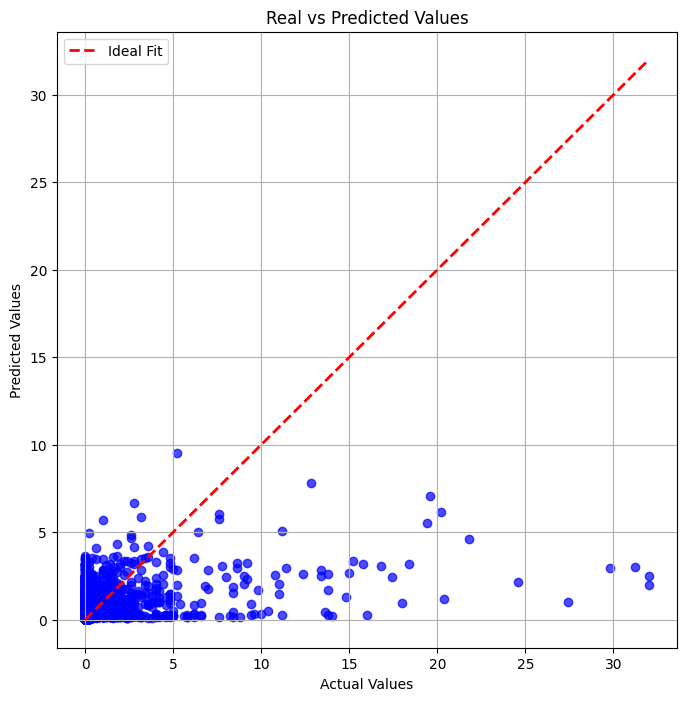

In [40]:
plot_real_vs_predicted(y_test, prec_predictions, save=r'C:\Users\F8091795\OneDrive - TIM\Pictures\xgb_prec_real_geral.png')


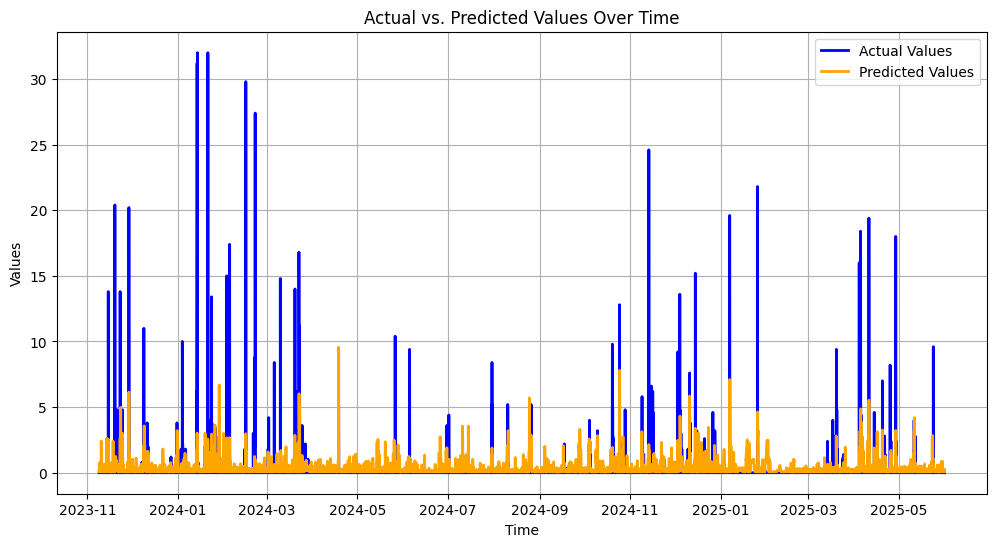

In [41]:
plot_prediction_over_time(y_test, prec_predictions, timestamps_test)


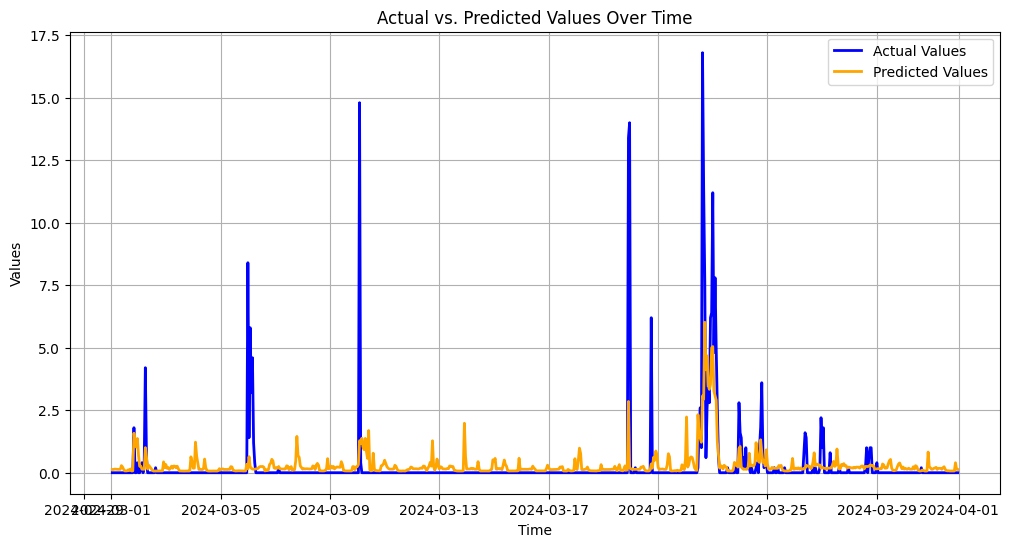

In [42]:
start_date = "2024-03-01 01:00:00"
end_date = "2024-03-31 23:00:00"

plot_prediction_over_time(y_test, prec_predictions, timestamps_test, start_date, end_date, save=r'C:\Users\F8091795\OneDrive - TIM\Pictures\xgb_prec_real_03-2024.png')

Temperatura Xgboost

In [43]:
X_train, X_test, y_train, y_test = split_train_test(X_temp, y_temp, 0.8)

tracker = EmissionsTracker(
    project_name="xgboost temperature train 0.8",
    output_file='./codecarbon_emissions.csv',
    log_level = "critical"
)

tracker.start()

temp_model, temp_predictions, temp_best_params = grid_search_xgboost(X_train, y_train, X_test, y_test)

emissions: float = tracker.stop()
print(f"emissions={emissions}")

Grid Search Progress: 100%|██████████| 243/243 [01:18<00:00,  3.09it/s]


Best parameters found:
{'max_depth': 4, 'eta': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.8, 'min_child_weight': 5, 'objective': 'reg:squarederror', 'eval_metric': 'rmse'}
Best RMSE: 7.440559889219756
emissions=6.367619243764473e-06


In [44]:
evaluate_model(y_test, temp_predictions)

MAE: 2.139974072325175
MSE: 7.440559889219756
MRSE: 2.727738970139877


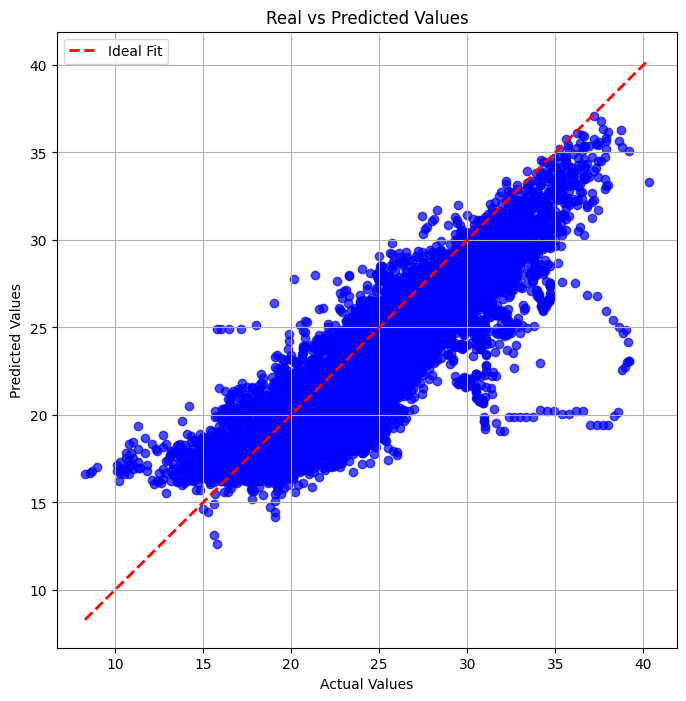

In [45]:
plot_real_vs_predicted(y_test, temp_predictions, save=r'C:\Users\F8091795\OneDrive - TIM\Pictures\xgb_temp_real_geral.png')


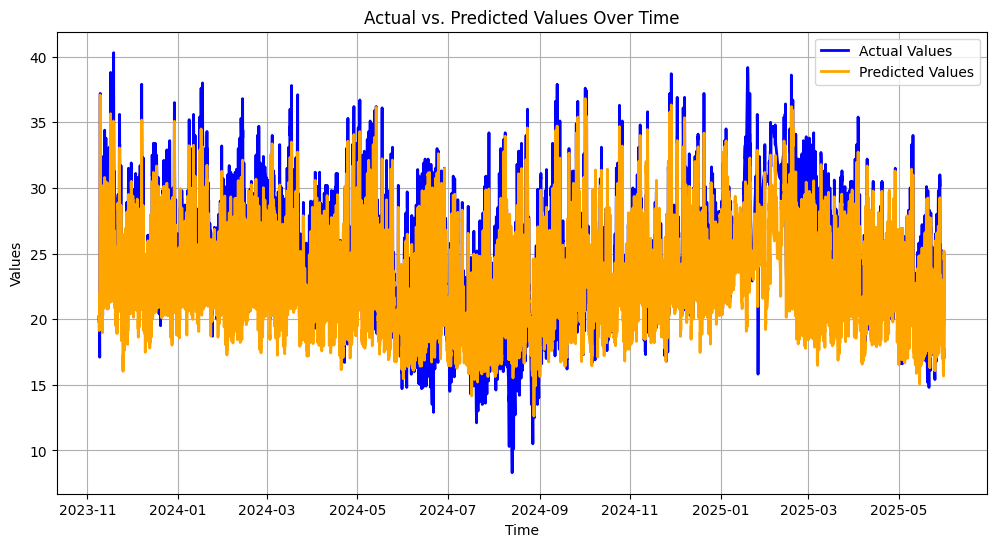

In [46]:
plot_prediction_over_time(y_test, temp_predictions, timestamps_test)

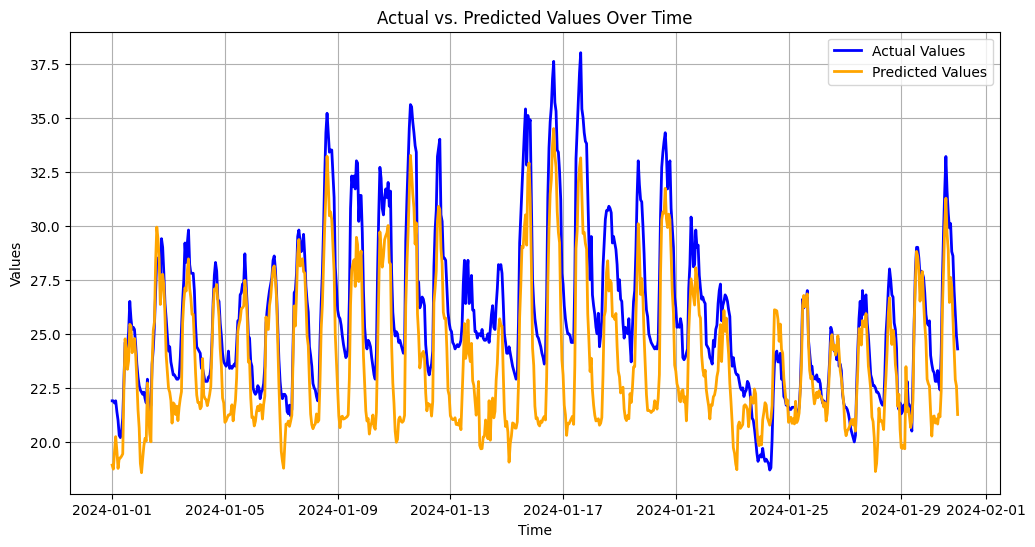

In [47]:
start_date = "2024-01-01"
end_date = "2024-01-31"

plot_prediction_over_time(y_test, temp_predictions, timestamps_test, start_date, end_date, save=r'C:\Users\F8091795\OneDrive - TIM\Pictures\xgb_temp_real_2024-01.png')

Umidade xgboost

In [48]:
X_train, X_test, y_train, y_test = split_train_test(X_umid, y_umid, 0.8)

tracker = EmissionsTracker(
    project_name="xgboost umidity train 0.8",
    output_file='./codecarbon_emissions.csv',
    log_level = "critical"
)

tracker.start()

umid_model, umid_predictions, umid_best_params = grid_search_xgboost(X_train, y_train, X_test, y_test)

emissions: float = tracker.stop()
print(f"emissions={emissions}")

Grid Search Progress: 100%|██████████| 243/243 [01:36<00:00,  2.52it/s]


Best parameters found:
{'max_depth': 6, 'eta': 0.2, 'subsample': 0.6, 'colsample_bytree': 0.6, 'min_child_weight': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse'}
Best RMSE: 75.16086273119512
emissions=7.77808034920332e-06


In [49]:
evaluate_model(y_test, umid_predictions)

MAE: 2.6707568838827935
MSE: 75.16086273119512
MRSE: 8.669536477297683


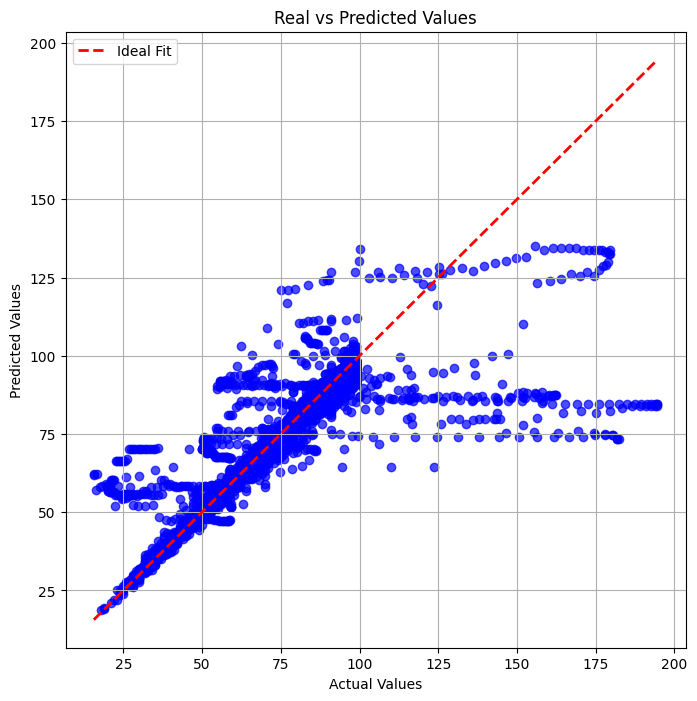

In [50]:
plot_real_vs_predicted(y_test, umid_predictions, save=r'C:\Users\F8091795\OneDrive - TIM\Pictures\xgb_umid_real_geral.png')


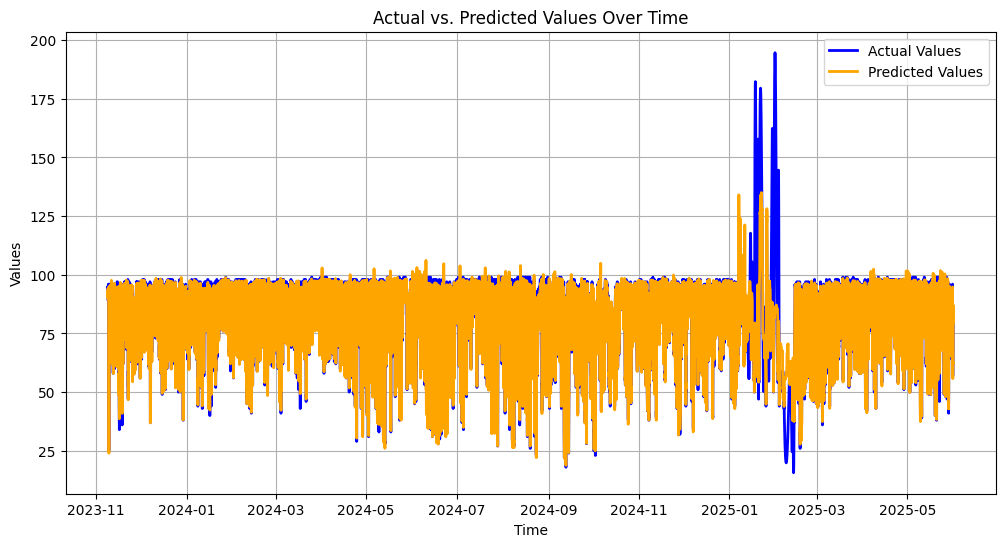

In [51]:
plot_prediction_over_time(y_test, umid_predictions, timestamps_test)

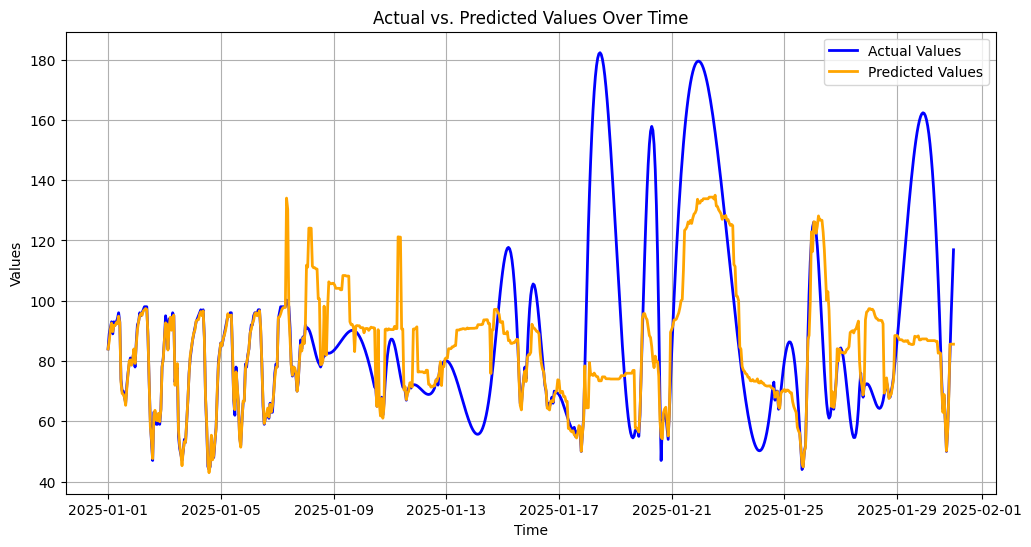

In [52]:
start_date = "2025-01-01"
end_date = "2025-01-31"

plot_prediction_over_time(y_test, umid_predictions, timestamps_test, start_date, end_date, save=r'C:\Users\F8091795\OneDrive - TIM\Pictures\xgb_umid_real_2024-01.png')

In [4]:
cdcarbon = pd.read_csv('codecarbon_emissions.csv', sep=',')
cdcarbon

,timestamp,project_name,run_id,experiment_id,duration,emissions,emissions_rate,cpu_power,gpu_power,ram_power,...,cpu_count,cpu_model,gpu_count,gpu_model,longitude,latitude,ram_total_size,tracking_mode,on_cloud,pue
0,2025-06-27T09:49:54,xgboost precipiptation train 0.8,080854a8-23b0-4eec-82e5-3bc25289fe81,5b0fa12a-3dd7-45bb-9766-cc326314d9f1,96.608089,0.000008,8.055763e-08,112.0,0.0,10.0,...,8,11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz,NaN,NaN,-71.2,46.8,15.710014,machine,N,1.0
1,2025-06-27T09:51:57,xgboost temperature train 0.8,651e7765-5cf1-4cfd-b992-7ef865ad2e61,5b0fa12a-3dd7-45bb-9766-cc326314d9f1,79.044579,0.000006,8.055732e-08,112.0,0.0,10.0,...,8,11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz,NaN,NaN,-71.2,46.8,15.710014,machine,N,1.0
2,2025-06-27T09:55:46,xgboost umidity train 0.8,db6a369a-7390-44e9-b489-fcb56feeb1e3,5b0fa12a-3dd7-45bb-9766-cc326314d9f1,96.553223,0.000008,8.055744e-08,112.0,0.0,10.0,...,8,11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz,NaN,NaN,-71.2,46.8,15.710014,machine,N,1.0
